## MNIST classification with random projections

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

First, we download the data. Mnist is so classic that it is already implemented in Keras. Let us see how data looks like

n_features=784
n_samples=70000 n_train=56000 n_test=14000
X_train: (56000, 784) y_train: (56000,)
X_test : (14000, 784) y_test : (14000,)


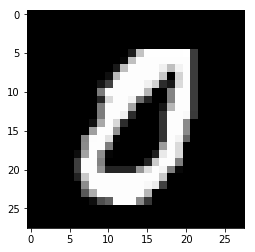

In [2]:
# get data
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
mnist = fetch_mldata("MNIST original", data_home="../lec1")
X, y = mnist.data, mnist.target
# Preprocess
X = X / 255.
# split between train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
n_samples, n_features = X.shape
n_train, n_test = X_train.shape[0], X_test.shape[0]
print(f"n_features={n_features}")
print(f"n_samples={n_samples} n_train={n_train} n_test={n_test}")
print(f"X_train: {X_train.shape} y_train: {y_train.shape}")
print(f"X_test : {X_test.shape} y_test : {y_test.shape}")

# Plot a sample
width = int(np.sqrt(n_features))
plt.imshow(X[10, :].reshape(width, width), cmap="gray");

MNIST is probably not easy to classify in direct space we shall not even try. Instead, we will try to go into a large dimensional space using random projection followed by a non linearity. Let us see how it works with $5000$ random projection followed by a function $\rm{erf}$. First we create the random matrix:

In [3]:
# one hot encoding of target 
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
Y_train = encoder.fit_transform(y_train.reshape(-1,1))
print(f"Y_train: {Y_train.shape}")

for s in range(3):
    print(f"sample {s}: y_train={y_train[s]} Y_train={Y_train[s]}")

Y_train: (56000, 10)
sample 0: y_train=2.0 Y_train=[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
sample 1: y_train=4.0 Y_train=[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
sample 2: y_train=7.0 Y_train=[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


In [4]:
from scipy.special import erf

# random projection
n_projections = 5000
F = np.random.randn(n_features, n_projections)/ np.sqrt(n_features)
# random feature map
A_train = erf(X_train @ F)
print(f"A_train: {A_train.shape}")

A_train: (56000, 5000)


Now, we want to perform a linear regression in the random features space of $A$. If we perform a simple regression, we have a model where we want to predict label by $Y=A \theta$. The  solution is obtained by writing 
$$\theta=(A^T A)^{-1} A^T Y$$
We thus create the correlation matrix $C=A^T A$ and the projection matrix $P=A^T Y$

In [5]:
C = A_train.T @ A_train
P = A_train.T @ Y_train

and we compute the coefficient $\theta$ by solving the linear system:

In [6]:
theta = np.linalg.lstsq(C, P)[0]
print(f"theta: {theta.shape}")

theta: (5000, 10)


Now that this is done, we can try to make a prediction for the elements of the test set. First, we need again to perform the projection for these digits:

In [7]:
# random feature map on test set
A_test = erf(X_test @ F)
print(f"A_test: {A_test.shape}")

A_test: (14000, 5000)


and we apply our linear prediction in features space

In [8]:
Y_pred = A_test @ theta
print(f"Y_pred: {Y_pred.shape}")

Y_pred: (14000, 10)


For each of the $10000$ digits, we now have a prediction saying how likely it belongs to the each of the $10$ classes. In order to choose the class, we gonna use the one that returns the largest elements:

In [9]:
y_pred = np.argmax(Y_pred, axis=1)
print(f"y_pred: {y_pred}")
accuracy = np.mean(y_pred == y_test)
print("Fraction of correct prediction is:", accuracy)

y_pred: [1 5 0 ..., 6 0 8]
Fraction of correct prediction is: 0.9655


This is not bad for a such a simple code. Beside, it is easy to go beyond to 98% with this approach by incerasing the number of projections, and playing with a regularization term.